# Final Project - Part B - Classification

## Loading the data

First, we will load the data we prepared in the previous task.

In [1]:
import pandas as pd

df = pd.read_csv('songs.csv')
lyrics = df['lyrics']
lyrics.head(3)

0    one  two  three  four   well  she was just sev...
1    the world is treating me bad misery  i'm the k...
2    anna you come and ask me  girl to set you free...
Name: lyrics, dtype: object

## Preparing the vocabulary

After loading the data we would like to builde a vocabulary.  
We will remove the stop word for saving only meaningful words, and then we will use Stemming to reduce inflected words.

In [16]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def important_words(song_lyrics):
    # remove stop words
    words = nltk.word_tokenize(song_lyrics)
    words = [w for w in words if not w in stop_words]
    # Stemming
    porter = nltk.PorterStemmer()
    words = [porter.stem(w) for w in words]
    return " ".join(words)

song_lyrics = [important_words(l) for l in lyrics]

Now, we that we have cleaned up the lyrics texts, we will create bag of words of all words.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Initialize the "CountVectorizer"  
vectorizer = CountVectorizer(analyzer="word", tokenizer=None, 
                             preprocessor=None, stop_words=None) 

train_data_features = vectorizer.fit_transform(song_lyrics[:])
train_data_features = train_data_features.toarray()

# Print the vocabulary size
vocab = vectorizer.get_feature_names()
print("Vocabulary size is: " + str(len(vocab)))

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# Print the lowest 10 frequencies
for tag, count in sorted(zip(vocab, dist) ,key=lambda song: song[1])[0:10]:
    print(count, tag)      

Vocabulary size is: 8606
1 12x
1 151
1 175
1 19
1 1998
1 23
1 28
1 29
1 2nd
1 2paclyps


We can see that there are 8606 words in our vocabulary.  
Many of them appear once, so lets take the top 10% using the max_features attribute.

In [18]:
# Initialize the "CountVectorizer" using max_features as 10% of all features 
vectorizer = CountVectorizer(analyzer="word", tokenizer=None, 
                             preprocessor=None, stop_words=None, 
                             max_features=int(len(vocab) * 0.1)) 

train_data_features = vectorizer.fit_transform(song_lyrics[:])
train_data_features = train_data_features.toarray() 

# Print the vocabulary size
vocab = vectorizer.get_feature_names()
print("New vocabulary size is: " + str(len(vocab)))

New vocabulary size is: 860


## Model training

We will now train a RandomForestClassifier with 100 estimator with 3 different datasets.  
For each one we will calculate the mean accuracy, using 10-fold cross validation.

### Random Forest 1

First we will train a RandomForest model, based on the top 10% of word frequencies.

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create a new RandomForestClassifier with 100 estimators
forest = RandomForestClassifier(n_estimators=100, random_state=1)

# cross validation with RandomForestClassifier
cross_val1 = cross_val_score(forest, train_data_features, df["singer"], cv=10)  
print(cross_val1)

[ 0.86440678  0.74576271  0.91525424  0.93103448  0.94736842  0.96491228
  0.91071429  0.875       0.875       0.91071429]


The results are not bad. However, maybe choosing the top 10% words is not the best way to choose the vocabulery size.  

### Random Forest 2

Maybe we should take the words that appear in at least 10% of the songs, which may give us better way to classify singer lyrics.  
Now, we will choose the vocabulary this way, using the min_df attribute.

In [87]:
# Initialize the "CountVectorizer"  using max_features as 10% of all features 
vectorizer2 = CountVectorizer(analyzer="word", tokenizer=None, 
                              preprocessor=None, stop_words=None, 
                              min_df=int(len(song_lyrics) * 0.1)) 

train_data_features2 = vectorizer2.fit_transform(song_lyrics)
train_data_features2 = train_data_features2.toarray() 

# Print the vocabulary size
vocab = vectorizer2.get_feature_names()
print("New vocabulary size is: " + str(len(vocab)))

# cross validation with RandomForestClassifier
cross_val2 = cross_val_score(forest, train_data_features2, df["singer"], cv=10)  
print(cross_val2)

New vocabulary size is: 186
[ 0.86440678  0.77966102  0.89830508  0.94827586  0.9122807   0.98245614
  0.92857143  0.89285714  0.89285714  0.92857143]


### Random Forest 3

We will also want to train a RandomForest model, that is based on tf-idf values.

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(analyzer="word", tokenizer=None, 
                                  ngram_range=(1,3), max_features=200, 
                                  stop_words=None, min_df=1, use_idf=True)

tfidf_matrix = tfidfvectorizer.fit_transform(song_lyrics)
tfidf_matrix = tfidf_matrix.toarray()
 
# cross validation with RandomForestClassifier
cross_val3 = cross_val_score(forest, tfidf_matrix, df["singer"], cv=10)  
print(cross_val3)

[ 0.84745763  0.76271186  0.89830508  0.93103448  0.9122807   0.89473684
  0.89285714  0.89285714  0.85714286  0.89285714]


### Plotting the results

We will now plot the results of the three models, to see which one gives us the best results.

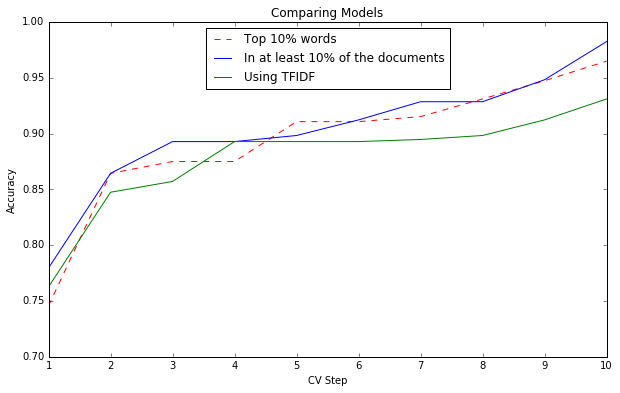

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10, 6

t = np.arange(1, 11, 1)
plt.plot(t, sorted(cross_val1), 'r--', label='Top 10% words')
plt.plot(t, sorted(cross_val2), 'b', label='In at least 10% of the documents')
plt.plot(t, sorted(cross_val3), 'g', label='Using TFIDF')
plt.ylabel('Accuracy')
plt.xlabel('CV Step')
plt.title('Comparing Models')
plt.legend(loc='upper center')
plt.show()

In [90]:
print("'Top 10%% Words' mean accuracy is %0.4f" % cross_val1.mean())
print("'In at least 10%% of the documents' mean accuracy is %0.4f" % cross_val2.mean())
print("'Using TFIDF' mean accuracy is %0.4f" % cross_val3.mean())

'Top 10% Words' mean accuracy is 0.8940
'In at least 10% of the documents' mean accuracy is 0.9028
'Using TFIDF' mean accuracy is 0.8782


From the comparison of the three models, we can see that all three give almost the same accuracy. So, we will choose the model "In at least 10% of the documents" because its mean accuracy is slightly better and it has less features.

### Final model

We will now split the dataset into two set - train set and test set, and based on them we will train our model and check its result.

In [92]:
from sklearn.model_selection import train_test_split

# Split to train & test of the dataset of 'In at least 10% of the documents'
x = train_data_features2
y = df['singer']

# We will split 
train_x, test_x, train_y, test_y = train_test_split(train_data_features2, y, test_size=0.2, random_state=123)

# We will use the Random Forest classifier we created and fit
# the forest to the training set, using the bag of words as 
# features and the singer labels as the response variable
forest = forest.fit(train_x, train_y)

# Evaluate accuracy best on the test set
print("Accuracy: %0.2f" % forest.score(test_x, test_y))

Accuracy: 0.92


Our model has an accuracy of **92%** for this train set and test set, and a mean accuracy of **90.28%** with the 10-fold cross-validation, which are not bad results!